In [1]:
import seaborn as sns

import sklearn
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score

import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm_notebook as tqdm
from __future__ import division
import pandas as pd
import seaborn as sb
import os
from scipy.spatial import distance
from scipy.cluster import hierarchy
from pandas import DataFrame

import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
import visualization_utils as vizutil
import matplotlib.cm as cm
from matplotlib.colors import Normalize
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

fishIdx = [("e", 2),  ("e", 5), ("c", 1),  ("c", 6),  ("enp", 1), ("enp", 5)]



import tensorflow as tf
from scipy import signal

# tf.enable_eager_execution()


# df, sig = f.get_cnmf_roi_table_and_signals()


# data = np.load("../cnmf_f01555.npz")
# cnmf = data['cnmf'].astype(np.float32)
# raw = data['raw'].astype(np.float32)
# del data

def moving_average(a, n=3):
    # a is a signal
    ret = np.cumsum(a,0) # sum over time
    ret[n:] = ret[n:] - ret[:-n] # diff of n samples back
    rm = ret[n - 1:] / n
    pad_start = np.full((n-1,rm.shape[1]), rm[0])
    return np.vstack([pad_start, rm])

def ewma(data,span):
    "exponential weighted moving average."
    df = DataFrame(data)
    return df.ewm(span).mean().values

def df_f(x,ma_window=6,span=6):
    u = moving_average(x,ma_window)
    return ewma((x - u)/u, span)

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

In [3]:
def pca(neurons, df):
    region_pca = {}
    for r in regions:
        X = neurons[:,df[r]]
        pca = PCA()
        pca.fit(X)
        transform = pca.fit_transform(X)
        region_pca[r] = {"components": pca.components_, "explained_var": pca.explained_variance_ratio_, "transform": transform}
    neurons_pca_transform = np.concatenate([region_pca[r]['transform'] for r in regions],1)
    return region_pca, neurons_pca_transform

In [4]:
def region_letter(x):
    return x[0][5]
def plot_pca(region_pca, f):
    N = len(region_pca)
    iterator = enumerate(sorted(region_pca.items(), key=region_letter))
    plt.figure()
    for i, (region, data) in iterator:
        nNeurons = sum(df[region])
        var = np.cumsum(data['explained_var'])
        sns.lineplot(nNeurons/np.arange(1,len(var)+1),var, label=region,
                     color=sns.color_palette('tab20')[i])
    plt.xlabel("Compression ( # neurons / # PCs)")
    plt.ylabel("Explained variance")
    plt.xlim(0,100)
    plt.legend(loc='best')
    plt.title(f.fishid)

def plot_pca_over_neurons(region_pca, f):
    N = len(region_pca)
    iterator = enumerate(sorted(region_pca.items(), key=region_letter))
    plt.figure()
    for i, (region, data) in iterator:
        nNeurons = sum(df[region])
        var = np.cumsum(data['explained_var'])
        sns.lineplot(np.arange(1,len(var)+1)/nNeurons,var, label=region,
                     color=sns.color_palette('tab20')[i])
    plt.xlabel("Compression ( # PCs / # neurons)")
    plt.ylabel("Explained variance")
#     plt.xlim(0,100)
    plt.legend(loc='best')
    plt.title(f.fishid)


In [5]:
def read_fish_data(indicator):
    f = all_data[fishIdx[indicator][0]][fishIdx[indicator][1]]
    M = f.get_signals_raw(z=None)
    neurons = M.T

    # neuron_ids = np.sort(np.argsort(neurons.std(0))[-5000:])
    df = f.get_roi_table()
    # df = df.iloc[neuron_ids]
    # df.reset_index(drop=True, inplace=True)
    # neurons = neurons[:,neuron_ids]


    neurons = signal.decimate(neurons,4, axis=0)

    neurons = df_f(neurons).astype(np.float32)
    neurons = (neurons - neurons.mean(0))/(neurons.std(0)+1e-8)
    return f, neurons, df

def get_pca_indicator(indicator):
    f, neurons, df = read_fish_data(indicator)
    return pca(neurons, df)
def plot_pca_indicator(indicator):
    region_pca, pca_transform = get_pca_indicator(indicator)
    plot_pca(region_pca, f)

# [plot_pca_indicator(i) for i in range(6)]
# pcas = [get_pca_indicator(i) for i in range(6)]

In [6]:
def make_pca_df(pcas, condition, fish_id, time_window):
    pca_df = DataFrame(columns=["condition", "fish_id", "time_window", "region", "pca_num", "explained_var"])
    region_pca, pca_transform = pcas
    iterator = enumerate(sorted(region_pca.items(), key=region_letter))
    for i, (region, data) in iterator:
        var = np.cumsum(data['explained_var'])
        df = pd.DataFrame({"condition": condition, "fish_id": fish_id, "time_window": time_window,
                           "region": region, "pca_num": np.arange(len(var)), "explained_var":var})
        pca_df = pca_df.append(df)
    return pca_df

In [7]:
ortho_regions = [u'in_l_cerebellum', u'in_r_cerebellum', 
    u'in_l_vthal', u'in_r_vthal', u'in_l_tectum', u'in_r_tectum', 
    u'in_l_raphe', u'in_r_raphe', u'in_l_hind', u'in_r_hind', 
    u'in_l_dthal', u'in_r_dthal', u'in_l_LHb', u'in_r_LHb', 
    u'in_l_tel', u'in_r_tel', u'in_l_MHb',  u'in_r_MHb']

_, _, df = read_fish_data(0)
regions = []
for r in ortho_regions:
    if r in df.columns:
        regions.append(r)

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/scipy/signal/signaltools.py:3445: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


 all_pca_df_filled = DataFrame.from_csv("all_pca_df_filled_no_decimate.csv")

In [8]:
#Params:
lag = 1
bExcludeMotion = False
bCNMF = False
dff_win = 500
decimate = None
bWhite = False
bWhiteByWindow = True
bTop = False
bOneWindow = True

fishids = [['f01606','f01604','f01547','f01550','f01553'],#,'f01597','f02326','f01520','f01527',],
           ['f01555','f01575','f01576','f01594','f01598'],
           ['f01736','f01732','f01733','f01735','f01729']]#,'f

In [10]:
all_pca_df = DataFrame(columns=["condition", "fish_id", "time_window", "region", "pca_num", "explained_var"])
for ncond, cond in enumerate(['shock','reexposed','control',]):
    for nf, fid in enumerate(fishids[ncond]):
        f = p2putils.get_fish(all_data,fid)[0]
        print('Starting', f.fishid)
        
        if bExcludeMotion:
            exclude_before = 1
            exclude_after = 4
            motion_frames = numpy.searchsorted(f.frame_et[:,-1], f.tail_movement_start_times,side="left")
            exclude_idx = np.unique((motion_frames[:,None] + np.arange(-exclude_before,exclude_after+1)[None]).flatten())
        else:
            exclude_idx = None
            
        
        #Load the signals
        if bCNMF:
            df, M = f.get_cnmf_roi_table_and_signals()
        else:
            M = f.get_signals_raw(z=None)
            df = f.get_roi_table()
        neurons = M.T  
#         print("INITIAL SHAPE", neurons.shape)
        #build time windows of frames to examine
        if bOneWindow:
            windows = [(0,np.argmax(f.frame_st[:,0]>(f.get_shock_start_time() + 60*24 + 360)))]
        else:
            window_len = 360
            windows = [(np.argmax(f.frame_st[:,0]>f.get_shock_start_time()-window_len), np.argmax(f.frame_st[:,0]>f.get_shock_start_time())),
                       (np.argmax(f.frame_st[:,0]>f.get_shock_start_time()),np.argmax(f.frame_st[:,0]>f.get_shock_start_time()+window_len)),
    #                    (neurons.shape[0]-360,neurons.shape[0])
                       (np.argmax(f.frame_st[:,0]>(f.get_shock_start_time() + 60*24)),np.argmax(f.frame_st[:,0]>(f.get_shock_start_time() + 60*24 + window_len))),
                       #(np.argmax(f.frame_st[:,0]>f.get_shock_start_time()-window_len), np.argmax(f.frame_st[:,0]>(f.get_shock_start_time() + 60*24 + window_len)))
                      ]
        
        #Extract top 5000 plus all in regions
        if bTop:
            bndx = np.zeros(df.shape[0],dtype=np.bool)
            for nReg, reg in enumerate(regions):
                if reg in df.columns:
                    bndx = bndx | df[reg]
            bndx[np.argsort(neurons.std(0))[-5000:]] = True
            neuron_ids = np.where(bndx)[0]
            df = df.iloc[neuron_ids]
            df.reset_index(drop=True, inplace=True)
            neurons = neurons[:,neuron_ids]
        print('num neurons %d'%(neurons.shape[1]))
        #Preprocess
        if not bCNMF: #if not CNMF loaded above
            neurons = df_f(neurons,dff_win,6) #6,6 or 500,6
        else: #else if CNMF data
            neurons = (neurons - neurons.mean(0))/neurons.mean(0) 
        if decimate is not None:
            neurons = signal.decimate(neurons,decimate,axis=0)
            windows = [(int(np.floor(w0/decimate)), int(np.floor(w1/decimate))) for w0,w1 in windows]
        if bWhite:
            neurons = (neurons - neurons.mean(0))/(neurons.std(0)+1e-8)
            ndx = np.where(neurons.std(0)==0)
            neurons[:,ndx] = 0
#         print("AFTER", neurons.shape)
        
        for it,window in enumerate(windows):
            wneurons = neurons[window[0]:window[1]]
            if bWhiteByWindow:
                wneurons = (wneurons - wneurons.mean(0))/(wneurons.std(0)+1e-8) #numericall reversible?
                ndx = np.where(wneurons.std(0)==0)
                wneurons[:,ndx] = 0
            # RUN ANALYSIS HERE
#             print(wneurons.shape)
            pcas = pca(wneurons, df)
            pca_df = make_pca_df(pcas, cond, fid, it)
            all_pca_df = all_pca_df.append(pca_df)
           
        # SAVE DATA
#         fn = f.data_prefix+'_pca.npz'
#         np.savez(fn, all_pcas[cond][fid][window])
        print('Done', f.fishid)#, fn)

Starting f01606
num neurons 14538
Done f01606
Starting f01604
num neurons 17382


/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:76: RuntimeWarning: invalid value encountered in true_divide


Done f01604
Starting f01547
num neurons 15282
Done f01547
Starting f01550
num neurons 17432
Done f01550
Starting f01553
num neurons 16713
Done f01553
Starting f01555
num neurons 15888
Done f01555
Starting f01575
num neurons 11939
Done f01575
Starting f01576
num neurons 10956
Done f01576
Starting f01594
num neurons 12800
Done f01594
Starting f01598
num neurons 12820
Done f01598
Starting f01736
num neurons 14746
Done f01736
Starting f01732
num neurons 14268
Done f01732
Starting f01733
num neurons 11722
Done f01733
Starting f01735
num neurons 11071
Done f01735
Starting f01729
num neurons 17635
Done f01729


In [11]:
# for viz purposes, if max(num_pca) < desired_pcas, then pad variance explained with 1. until desired_pca
desired_pcas = 100
all_pca_df_filled = all_pca_df.query("pca_num<100").copy()
for ncond, cond in enumerate(['shock','reexposed','control',]):
    for nf, fid in enumerate(fishids[ncond]):
        for it in range(len(windows)):
            for r in regions:
                q = 'fish_id=="{}" and region=="{}" and time_window=={} and pca_num<100'.format(fid, r, it)
                rows = all_pca_df.query(q)
                if len(rows)==100 or len(rows)==0:
                    continue
                else:
                    npcas = len(rows)
#                     print(fid, cond, it, r, npcas)
    #                 print(row)
                    filled_df = pd.DataFrame({"condition": cond, "fish_id": fid, "time_window": it,
                           "region": r, "pca_num": np.arange(npcas,desired_pcas+1, dtype=int), "explained_var":1.})
                    all_pca_df_filled = all_pca_df_filled.append(filled_df)
                
# all_pca_df_filled.query('fish_id=="f01553" and region=="in_r_raphe" and condition=="shock"')

In [12]:
all_pca_df_filled.to_csv("all_neurons_pca_df_filled_no_decimate_whiten_one_window.csv")

In [18]:
dat = all_pca_df_filled.query('condition == "control" and time_window==0')
nregions = len(dat["region"].unique())

In [14]:
sns.set()

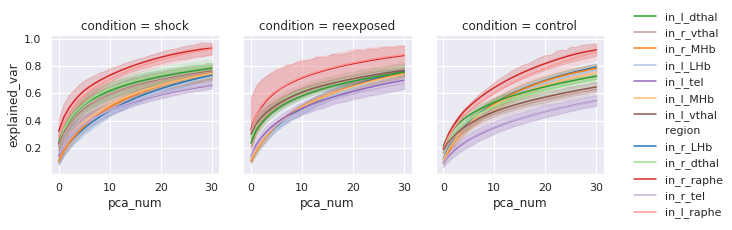

In [23]:
dat = all_pca_df_filled.query('pca_num<=30')
g = sns.FacetGrid(dat, col="condition", margin_titles=True)
g.map(sns.lineplot, "pca_num", "explained_var", "region",
     palette=sns.color_palette('tab20')[:nregions])
g.add_legend()

In [29]:
# find n_pca needed to explain >= desired_var
desired_var = 0.5
if windows:
    nwindows = len(windows)
else:
    nwindows = 3    
all_n_pca_df = DataFrame(columns=[u'condition', u'fish_id', u'pca_num', u'region',
       u'time_window'])
for ncond, cond in enumerate(['shock','reexposed','control',]):
    for nf, fid in enumerate(fishids[ncond]):
        for it in range(nwindows):
            for r in regions:
                q = 'fish_id=="{}" and region=="{}" and time_window=={} and explained_var>={}'.format(fid, r, it, desired_var)
                rows = all_pca_df.query(q)
                if len(rows)==0:
                    continue
                else:
                    pca_n = float(rows.iloc[0].pca_num)
                    n_pca_df = pd.DataFrame({"condition": cond, "fish_id": fid, "time_window": it,
                           "region": r, "pca_num": [pca_n]})
                    all_n_pca_df = all_n_pca_df.append(n_pca_df)
                

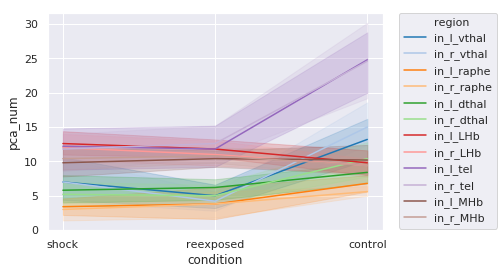

In [30]:
dat = all_n_pca_df
sns.lineplot("condition", "pca_num", "region", sort = False,
     data=dat, palette=sns.color_palette('tab20')[:nregions])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

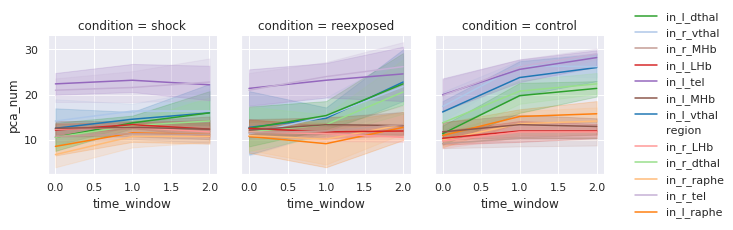

In [16]:
dat = all_n_pca_df
g = sns.FacetGrid(dat, col="condition", margin_titles=True)
g.map(sns.lineplot, "time_window", "pca_num", "region",
     palette=sns.color_palette('tab20')[:nregions])
g.add_legend()

In [48]:
dat.query('time_window==0 and region=="in_l_vthal"')

,condition,fish_id,pca_num,region,time_window
0,control,f01736,0,in_l_vthal,0
0,control,f01732,1,in_l_vthal,0
0,control,f01733,1,in_l_vthal,0
0,control,f01735,0,in_l_vthal,0
0,control,f01729,1,in_l_vthal,0


In [51]:
dat.dtypes

condition      object
fish_id        object
pca_num        object
region         object
time_window    object
dtype: object

In [49]:
# dat = all_pca_df.query('time_window == 1 and fish_id == "f01606" and condition == "shock"')
dat = all_n_pca_df.query('condition == "control"')
nregions = len(dat["region"].unique())
ax = sns.lineplot(x="time_window", y="pca_num", hue="region", data=dat,
                  palette=sns.color_palette('tab20')[:nregions])
# ax.set_xlim(0,100)

ValueError: could not convert string to float: in_r_MHb

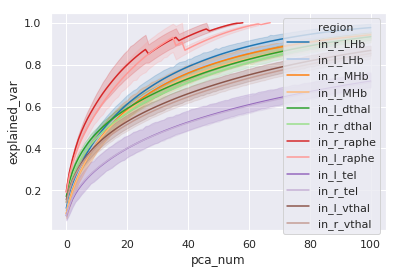

In [177]:
# dat = all_pca_df.query('time_window == 1 and fish_id == "f01606" and condition == "shock"')
dat = all_pca_df.query('condition == "control" and time_window==1 and pca_num <=100')
nregions = len(dat["region"].unique())
ax = sns.lineplot(x="pca_num", y="explained_var", hue="region", data=dat,
                  palette=sns.color_palette('tab20')[:nregions])
# ax.set_xlim(0,100)

In [205]:
all_pca_df.query('condition == "control" and time_window==1 and pca_num <=100').head()

,condition,explained_var,fish_id,pca_num,region,time_window
0,control,0.080324,f01736,0,in_r_LHb,1
1,control,0.130012,f01736,1,in_r_LHb,1
2,control,0.177523,f01736,2,in_r_LHb,1
3,control,0.215037,f01736,3,in_r_LHb,1
4,control,0.248598,f01736,4,in_r_LHb,1


In [206]:
all_pca_df.query('condition == "control" and time_window==0 and pca_num <=100').head()

,condition,explained_var,fish_id,pca_num,region,time_window
0,control,0.080324,f01736,0,in_r_LHb,0
1,control,0.130012,f01736,1,in_r_LHb,0
2,control,0.177523,f01736,2,in_r_LHb,0
3,control,0.215037,f01736,3,in_r_LHb,0
4,control,0.248598,f01736,4,in_r_LHb,0
